In [1]:
import argparse
from collections import defaultdict
import matplotlib
# matplotlib.use('Agg') 

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def plot_exon(locs,ax,h=0.25,offset = 0,bin_size=400,alpha=1,color="k",ecolor="k"):
#   print("plotting exon")
  ax.add_patch(Rectangle((locs[0], -h + offset), locs[1] - locs[0], 2*h,edgecolor=ecolor,color=color,alpha=alpha,linewidth=0))

def load_gtf(gtf_file,filt_chr):
  gtf = pd.read_csv(gtf_file, names = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"], sep="\t")
  if 'NC_000023.11' in gtf["seqname"].unique():
    can_chrom = [x for x in gtf["seqname"].unique() if x.startswith("NC_")]
    name_dict = {x : "chr" + str(int(x.split("_")[1].split(".")[0])) for x in can_chrom}
    name_dict['NC_000023.11'] = "chrX"
    name_dict['NC_000024.10'] = "chrY"
    name_dict['NC_012920.1'] = "chrM"
    gtf["seqname"] = gtf["seqname"].map(name_dict)
    gtf = gtf[~gtf["seqname"].isna()]
    filt_chr = False
  #   gtf = gtf[gtf["feature"] == "exon"]
  try:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_name").str[1].str.split(";").str[0].str.split('"').str[1]
  except:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_id").str[1].str.split(";").str[0].str.split('"').str[1]
  gtf["transcript_id"] = gtf["attribute"].str.split("transcript_id").str[1].str.split(";").str[0].str.split('"').str[1]
#  filt_chr = True
  if filt_chr:
    # don't include immature scaffolds
    chromosomes = gtf["seqname"].unique()
    chromosomes = [x for x in chromosomes if "_" not in x and not x.startswith("KN")]
#    print("chromosomes",chromosomes)
    gtf = gtf[gtf["seqname"].isin(chromosomes)]
  gtf["chr_gene"] = gtf["seqname"] + gtf["gene_id"]
  return gtf


def annotation_plot(gtf, domains, gene, end,outpath, dataname, suff):
  rev_dict = {"A" : "B","B" : "A"}

  # gene = "CALD1"
  # end = 134928754
  don_df = pd.read_csv("{}{}_{}_{}_coords.tsv".format(outpath,dataname,gene,end),sep="\t")
  don_df = don_df.rename(columns={"rank_acc" : "rank", "rank_don" : "rank"}).astype(int)


  if don_df["juncPosR1A"].nunique() == 1:
    let = "A"
  else:
    let = "B"

  shared_ends = list(don_df["juncPosR1" + rev_dict[let]])

  zoom = True
  # for gene in genes:
  gene_gtf = gtf[gtf["gene_id"] == gene]
  gene_gtf = gene_gtf[gene_gtf["feature"].isin(["exon"])]

  legend = True

  if don_df["juncPosR1" + rev_dict[let]].nunique() > 1:

    colors = 5*[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf',u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    someX, someY = 0.5, 0.5
    plt.figure(figsize=(12, 6))
    h = 1
    offset = 1
    currentAxis = plt.gca()
    count = 1
    y_labels = []
    arc_height = 10
    y_ticks = []
    arcs = False
    chromosome = gene_gtf["seqname"].iloc[0]
    gene_min_all = gene_gtf["start"].min()
    gene_max_all = gene_gtf["end"].max()

    legend_elements = []

    gene_domains = domains[(domains[1] == chromosome) & (domains[2] < gene_max_all) & (domains[3] > gene_min_all)]

    # if arcs:
    # count = 1
    if gene_gtf["strand"].iloc[0] == "+":
      asc = True
    else:
      asc = False

  #   plt.text(row["juncPosR1" + rev_dict[let]],gene_gtf["transcript_id"].nunique() + 1,row["rank"],horizontalalignment="center")
    for ind, row in don_df.iterrows():
        plt.text(row["juncPosR1" + rev_dict[let]],gene_gtf["transcript_id"].nunique() + 1,row["rank"],horizontalalignment="center")
        plt.plot([row["juncPosR1" + rev_dict[let]],row["juncPosR1" + rev_dict[let]]],[ -0.5,gene_gtf["transcript_id"].nunique() + 0.5],color="red")
    plt.plot([row["juncPosR1" + let],row["juncPosR1" + let]],[ -0.5,gene_gtf["transcript_id"].nunique() + 0.5],color="blue")


    count = 0
    for transcript, trans_df in gene_gtf.groupby("transcript_id"):
      y_labels.append(transcript)
      y_ticks.append(count * offset)
      gene_min = trans_df["start"].min()
      gene_max = trans_df["end"].max()
      plt.plot([gene_min,gene_max],[offset * count,offset * count],color="k")

      for exons in set([tuple(x) for x in trans_df[["start","end"]].to_numpy()]):
        plot_exon(exons,currentAxis,offset = count * offset)
      i = 0
      for d in set([tuple(x) for x in gene_domains[[2,3,4]].to_numpy()]):
        plot_exon(d[:2],currentAxis,offset = count * offset,alpha = 0.4,color=colors[i],ecolor=None,h=0.5)
        legend_elements.append(Patch(facecolor=colors[i], edgecolor=None,label=d[2],alpha=0.4))
        i += 1

      count += 1

    if arcs:
      plt.ylim([-1,gene_gtf["transcript_id"].nunique() + arc_height + 1])
    else:
      plt.ylim([-1,gene_gtf["transcript_id"].nunique() + 2])

    currentAxis.ticklabel_format(useOffset=False,style="plain")
    if legend:
      currentAxis.legend(handles=legend_elements[:gene_domains.shape[0]],bbox_to_anchor=(1., 1.0))
    plt.yticks(y_ticks,y_labels)
  #   plt.xlim([gene_min_all,gene_max_all])
    if zoom:
      print("end",end,"shared_ends",shared_ends)
      buff = max([abs(x - end) for x in shared_ends])/12
      plt.xlim(min([end] + shared_ends) - buff,max([end] + shared_ends) + buff)
    else:
      plt.xlim([gene_min_all,gene_max_all])

    plt.title("{} {} {}".format(gene,chromosome,end))
#    try:
    plt.show()
    plt.savefig("{}{}{}_{}_don_ann{}.png".format(outpath,dataname,gene,end,suff),bbox_inches = "tight")
    plt.close()
#    except Exception as e:
#      print(e)

## create a color dictionary for donors
#def compartment_colors(compartments):
#    
#    import matplotlib.colors as pltcolors
#    
#    cmap = plt.cm.get_cmap("YlOrRd")
#        
#    compartment_color_dict = {}
#    j=1/len(compartments)
#    for c in compartments:
#        compartment_color_dict[c] = pltcolors.to_hex(cmap(j))
#        j+=1/len(compartments)
#        
#    return compartment_color_dict

# create a color dictionary for donors (our colors)
def compartment_colors(compartments):
    compartment_color_dict = {comp : col for comp, col in zip(compartments,sns.color_palette("deep",len(compartments)))}

    # ensure same colors for key compartments
    palette = sns.color_palette("deep",4)
    compartment_color_dict["Endothelial"] = palette[0]
    compartment_color_dict["endothelial"] = palette[0]
    compartment_color_dict["Epithelial"] = palette[1]
    compartment_color_dict["epithelial"] = palette[1]
    compartment_color_dict["Immune"] = palette[2]
    compartment_color_dict["immune"] = palette[2]
    compartment_color_dict["Stromal"] = palette[3]
    compartment_color_dict["stromal"] = palette[3]
    return compartment_color_dict


def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
#              'Fat': '#e7cb94',
#              'Heart': '#637939',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Skin': '#ce6dbd',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Trachea': '#969696',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

def get_args():
  parser = argparse.ArgumentParser(description="make box plots for each donor and acceptor")
  parser.add_argument("--dataname",help="name of dataset to use")
  parser.add_argument("--letter",help="which letter; donor: A, acceptor: B")
  parser.add_argument("--params",help="file of parameters to make plots for")
  parser.add_argument("--organism",choices=["lemur","human","mouse"],default="human",help="organism of submitted data")
  parser.add_argument("--subfolder",help="subfolder to save in")
  parser.add_argument("--cell_lim",type=int,default=20,help="number of cells to limit ontologies to")


  args = parser.parse_args()
  return args

def dot_plot(don_df, let, let_dict, palette, onts, outpath, gene, don, tiss, dataname, rev_dict, domains,gtf, alpha, suff):
#  print("in dot")
  don_df["ontology_rank"] = don_df["ontology"] + don_df["rank_" + let_dict[let]].astype(str)
  don_df["rank_count"] = don_df["ontology_rank"].map(don_df.groupby("ontology_rank")["numReads"].sum())
  ont_dict = {o : i for o, i in zip(onts,range(1,don_df["ontology"].nunique() + 1))}
  don_df["ont_num"] = don_df["ontology"].map(ont_dict)
  pdf = don_df.drop_duplicates("ontology_rank")
  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["rank_count"].sum())
  pdf["frac_rank"] = pdf["rank_count"] / pdf["rank_sum"]
  print("ranks",pdf["rank_" + let_dict[let]].value_counts())
  pdf["rank_" + let_dict[let]] = pdf["rank_" + let_dict[let]].astype(int)

  ann_dict = pd.Series(pdf.splice_ann.values,index=pdf["rank_" + let_dict[let]]).to_dict() 
  coords = pdf.drop_duplicates("rank_" + let_dict[let])[["rank_" + let_dict[let],"juncPosR1A","juncPosR1B"]]
  coords = coords[coords["rank_" + let_dict[let]].isin(range(1,int(coords["rank_" + let_dict[let]].max() + 1)))].sort_values("rank_" + let_dict[let])
  end = int(coords["juncPosR1" + let].iloc[0])
  coords.to_csv("{}{}_{}_{}_coords.tsv".format(outpath,dataname,gene,end),sep="\t",index=False)
  try:
    annotation_plot(gtf, domains, gene, end,outpath, dataname,suff)
  except Exception as e:
    print("tried annotation plot",e)


  print("ann_dict",ann_dict)
#  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["scaled_rank"].sum())
#  pdf["scaled_rank"] = pdf["scaled_rank"] / pdf["rank_sum"]
  g = sns.relplot(x="rank_" + let_dict[let], y="ont_num", size="frac_rank",
              sizes=(10, 400), alpha=alpha, palette=palette,hue="compartment",
              height=max(4,pdf["ontology"].nunique()*0.3), data=pdf)
#  for tick_label in g.ax.get_xticklabels():
#    try:
#      if float(tick_label.get_text()) in ann_dict.keys():
#        if ann_dict[int(float(tick_label.get_text()))]:
#          tick_label.set_color("blue")
#        else:
#          tick_label.set_color("red")
#    except Exception as e:
#      print(e)

#     onts = []
#     vals = []
#     for key, value in ont_dict.items():
#       onts.append(key)
#       vals.append(value)
  plt.yticks(range(1,don_df["ontology"].nunique() + 1),onts)
  plt.title("{}\n{} {} {} {}".format(dataname,gene,tiss, don, let_dict[rev_dict[let]]))
  plt.show()
  plt.savefig("{}{}_{}_{}_{}_{}_dot{}.png".format(outpath, gene, don, tiss, dataname, let_dict[rev_dict[let]],suff),bbox_inches="tight")
#  print("saved")
  plt.close()
  return 0

def plot_df(df, let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, don,tiss, don_df, comp_sort,suff, dataname_dict):
    expand_dict = {"don" : "donor","acc" : "acceptor"}
#    df["num_cells"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
#
#    df = df[df["num_cells"] > cell_lim]

    # calculate ontology-wide values to sort on
    df["ont_rank"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].median())
    df["ont_75"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].quantile(0.75))
    df["ont_25"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].quantile(0.25))

    df["ont_max"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].max())
    df["ont_min"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].min())
    if comp_sort:
      df = df.sort_values(by=["compartment","free_annotation"])
    else:
      df = df.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"])

    ann_dict = pd.Series(df.splice_ann.values,index=df["rank_" + let_dict[let]]).to_dict() 
    df["sort_num"] = df["ontology"].map({x : y for x, y in zip(focus,range(len(focus)))})
    df = df.sort_values("sort_num")
    num_cells = list(df.drop_duplicates("ontology")["num_cells"])
    df["sum_reads"] = df["ontology"].map(df.groupby("ontology")["numReads"].sum())
    num_reads = list(df.drop_duplicates("ontology")["sum_reads"])
    medians = list(df.drop_duplicates("ontology")["ont_rank"])
    comp_dict = {"Endothelial" : u'#1f77b4', "Epithelial" : u'#ff7f0e', "Immune" : u'#2ca02c',"Stromal" :  u'#d62728'}
    if df.shape[0] > 0:
      fig,(ax2) = plt.subplots(1,figsize=(7,5))
#       fig, ax = pyplot.subplots(figsize=a4_dims)
      g = sns.boxplot(x="avg_rank", y="ontology",hue="compartment",dodge=False,
                       data=df,ax=ax2,palette = comp_dict)
      g.axes.set_ylabel('') 
      g.axes.set_xlabel('average {} rank per cell'.format(expand_dict[let_dict[let]])) 
#    for tick_label in g.ax.get_xticklabels():
#    for i in range(len(ax2.get_xticklabels())):
#      try:
#        if ax2.get_xticks()[i] in ann_dict.keys():
#          if ann_dict[int(float(tick_label.get_text()))]:
#            ax2.get_xticklabels()[i].set_color("blue")
#          else:
#            ax2.get_xticklabels()[i].set_color("blue")
#      except Exception as e:
#        print(Exception)

#    for tick_label in ax2.get_xticks():

#      try:
#        if float(tick_label.get_text()) in ann_dict.keys():
#          if ann_dict[int(float(tick_label.get_text()))]:
#            tick_label.set_color("blue")
#          else:
#            tick_label.set_color("red")
#      except Exception as e:
#        print(Exception)

      for i,artist in enumerate(ax2.artists):
          # Set the linecolor on the artist to the facecolor, and set the facecolor to None
          col = artist.get_facecolor()
          artist.set_edgecolor(col)
          artist.set_facecolor('None')

          # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
          # Loop over them here, and use the same colour as above
          for j in range(i*6,i*6+6):
              line = ax2.lines[j]
              line.set_color(col)
              line.set_mfc(col)
              line.set_mec(col)

      # Also fix the legend
      for legpatch in ax2.get_legend().get_patches():
          col = legpatch.get_facecolor()
          legpatch.set_edgecolor(col)
          legpatch.set_linewidth(10)
          legpatch.set_facecolor('None')
#         medians = df.groupby("ontology")["avg_rank"].median()
      for i in range(len(num_reads)):
        plt.text(df["avg_rank"].max() + (df["avg_rank"].max() - df["avg_rank"].min())/12,i, int(num_reads[i]))


        plt.scatter([medians[i]],[i],color = "k",s=20,zorder=100)
      g.legend_.remove()
      plt.title("{}\n{} {} {} {}\nmean: {:0.2f} median: {:0.2f}".format(dataname_dict.get(dataname,dataname),gene,tiss, don[:-len(gene)], expand_dict[let_dict[rev_dict[let]]], don_df["avg_rank"].mean(), don_df["avg_rank"].median()))
#      plt.legend(bbox_to_anchor=(1.5, 1.05))
      
      plt.savefig("{}{}_{}_{}_{}_{}{}_{}.pdf".format(outpath, gene, don, tiss, dataname, let_dict[rev_dict[let]],suff,cell_lim),bbox_inches="tight",transparent=True)
      plt.savefig("{}{}_{}_{}_{}_{}{}_{}.png".format(outpath, gene, don, tiss, dataname, let_dict[rev_dict[let]],suff,cell_lim),bbox_inches="tight")

      print("saved","{}{}_{}_{}_{}_{}{}_{}.pdf".format(outpath, gene, don, tiss, dataname, let_dict[rev_dict[let]],suff,cell_lim))
      plt.show()
      plt.close()
      return df


def box(df, let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, domains, gtf, alpha, comp_sort, suff, dataname_dict):

  for don, don_df in df.groupby("pos{}_group".format(let)):
    temp = plot_df(don_df.drop_duplicates("pos{}_cell".format(let)), let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, don,"all", don_df, comp_sort,suff, dataname_dict)
    if not temp is None:
      if temp["ontology"].nunique() > 0:
        onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())
        onts.reverse()
        response = dot_plot(don_df, let, let_dict, palette,onts, outpath, gene, don, "all", dataname, rev_dict,domains,gtf, alpha, suff)
    for tiss, tiss_df in don_df.groupby("tissue"):
      temp = plot_df(tiss_df.drop_duplicates("pos{}_cell".format(let)), let, cell_lim, outpath, gene, dataname, let_dict, palette, rev_dict, don,tiss, don_df, comp_sort,suff, dataname_dict)
      if not temp is None:
        if temp["ontology"].nunique() > 0:
          onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())
          onts.reverse()
          response = dot_plot(tiss_df, let, let_dict, palette,onts,outpath, gene, don, tiss, dataname, rev_dict, domains,gtf, alpha, suff)
          if type(response) != int:
            print("ERROR")
            return response

In [8]:
dataname_dict = {"HLCA4_P2_10x_with_postprocessing_lung" : "HLCA individual 1", "HLCA4_P3_10x_with_postprocessing_lung" : "HLCA individual 2"}

organism = "human"
dataname = "TSP2_10x_rerun_with_postprocessing_3prime_cellann"
# letter = "B"

# subfolder = "first_evec"
cell_lim = 0

# args = get_args()
#  dataname = "TS_10x_redo"
df = pd.read_parquet("../data/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(dataname),columns=["tissue","compartment","free_annotation","geneR1A_uniq","posA_group","posB_group","cell", "juncPosR1A", "juncPosR1B", "numReads", "splice_ann"])
outpath = "output/donor_boxplots/"

domains = pd.read_csv("../utility_files/ucscGenePfam.txt",sep="\t",header=None)
# loaletterd gtf
# gtf_file = "/scratch/PI/horence/JuliaO/single_cell/STAR_wrapper/gtf_files/hg38.ncbiRefSeq.gtf" 
# gtf_file = "/oak/stanford/groups/horence/circularRNApipeline_Cluster/index/hg38_genes.gtf"
if organism == "human":
#    gtf_file = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/GRCh38_latest_genomic.gtf"
  gtf_file = "../utility_files/grch38_known_genes.gtf"
elif organism == "lemur":
  gtf_file = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/SICILIAN_references/lemur/ref_Mmur_3.0.gtf"
elif organism == "mouse":
  gtf_file = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/SICILIAN_references/mouse/refseq_GRCm38.p6/GCF_000001635.26_GRCm38.p6_genomic.gtf"

gtf = load_gtf(gtf_file,False)

#  gtf["gene_id"] = gtf["gene_id"].replace("FYB1","FYB")
#  gtf["gene_id"] = gtf["gene_id"].replace("ATP5F1C","ATP5C1")

# only include ontology/gene pairs with at least 20 cells
#  cell_lim = 20
df["ontology"] = df["tissue"] + df["compartment"] + df["free_annotation"]
df["ontology_gene"] = df["ontology"] + df["geneR1A_uniq"]
df["ontology_don"] = df["ontology"] + df["posA_group"]
df["ontology_acc"] = df["ontology"] + df["posB_group"]
df["num_cells"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell"].nunique())

df = df[df["num_cells"] > cell_lim]
df["num_cell_ont"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell"].nunique())
df = df[df["num_cell_ont"] > cell_lim]

In [17]:
# params = "../utility_files/PNRC1.tsv"
# letter = "B"
# focus = ["MuscleStromalskeletal muscle satellite stem cell","MuscleEndothelialcapillary endothelial cell",
# "MuscleStromalpericyte cell","MuscleStromalmesenchymal stem cell","MuscleEndothelialendothelial cell of vascular tree",
#         'ThymusEndothelialvein endothelial cell',"LungEndothelialcapillary endothelial cell",
#         'BloodImmunecd4-positive helper t cell','SpleenImmuneclassical monocyte','BloodImmuneclassical monocyte',
#         'BladderImmuneplasma cell','VasculatureStromalsmooth muscle cell','LungEpithelialbasal cell',
#         'SpleenImmuneplasma cell','SpleenImmunemature nk t cell','BladderImmunemacrophage',
#          'Lymph_NodeImmunememory b cell','SpleenImmunememory b cell','Lymph_NodeImmuneinnate lymphoid cell',
#          'BladderStromalpericyte cell',"BladderEpithelialbladder urothelial cell",
#          'BladderStromalfibroblast','LungEpithelialtype ii pneumocyte','VasculatureStromalpericyte cell',
#          'TracheaEpithelialbasal cell','VasculatureStromalfibroblast','BladderStromalmyofibroblast cell',
#          'LungStromalaveolar fibroblast','MuscleImmunemacrophage'
         
#         ]

# params = "../utility_files/FYB1.tsv"
# letter = "B"
# focus = ['BloodImmunecd4-positive helper t cell','BloodImmuneintermediate monocyte',
#         'BloodImmuneclassical monocyte','SpleenImmuneclassical monocyte','LungImmunemacrophage',
#         'MuscleImmunemacrophage']

# params = "../utility_files/LIMCH1.tsv"
# letter = "A"
# focus = ["BladderEpithelialbladder urothelial cell",'LungEpithelialtype ii pneumocyte','LungEpithelialclub cell','LungEpithelialbasal cell',
#         'VasculatureStromalsmooth muscle cell','BladderStromalfibroblast','LungStromalaveolar fibroblast',"MuscleStromalmesenchymal stem cell"]

# params = "../utility_files/MYL6.tsv"
# letter = "A"
# focus = ['MuscleStromalskeletal muscle satellite stem cell',
#  'LungStromalfibroblast',
#  'MuscleStromaltendon cell',
#  'MuscleStromalmesenchymal stem cell',
#  'MuscleStromalpericyte cell',
#  'LungStromalvascular associated smooth muscle cell',
#  'LungStromalaveolar fibroblast',
#  'LungStromalmyofibroblast cell',
#  'LungStromalbronchial smooth muscle cell',
#  'LungStromalmesothelial cell',
#  'LungImmuneplasma cell',
#  'MuscleImmunet cell',
#  'LungImmunemacrophage',
#  'LungImmunedendritic cell',
#  'MuscleImmunemacrophage',
#  'LungImmunenatural killer cell',
#  'LungImmunecd8-positive, alpha-beta t cell',
#  'MuscleImmunecd4-positive, alpha-beta t cell',
#  'LungImmunenon-classical monocyte',
#  'LungImmuneclassical monocyte',
#  'LungEpithelialionocyte',
#  'LungEpithelialadventitial cell',
#  'LungEpithelialclub cell',
#  'LungEpithelialbasal cell',
#  'LungEpithelialtype i pneumocyte',
#  'BladderEpithelialbladder urothelial cell',
#  'LungEpithelialrespiratory goblet cell',
#  'LungEpitheliallung ciliated cell',
#  'LungEpithelialserous cell of epithelium of bronchus',
#  'LungEpithelialtype ii pneumocyte',
#  'MuscleEndothelialendothelial cell of artery',
#  'LungEndotheliallung microvascular endothelial cell',
#  'LungEndothelialvein endothelial cell',
#  'LungEndothelialcapillary aerocyte',
#  'BladderEndothelialvein endothelial cell',
#  'LungEndothelialcapillary endothelial cell',
#  'LungEndothelialendothelial cell of artery',
#  'MuscleEndothelialendothelial cell of lymphatic vessel',
#  'MuscleEndothelialcapillary endothelial cell',
#  'MuscleEndothelialendothelial cell of vascular tree']
# focus.reverse()

params = "../utility_files/TPM1.tsv"
letter = "B"
focus = ['MuscleEndothelialcapillary endothelial cell',
 'BladderEndothelialvein endothelial cell',
 'MuscleEndothelialendothelial cell of vascular tree',
 'MuscleImmunemacrophage',
 'BloodImmuneplatelet',
 'BladderImmunemacrophage',
 'MuscleStromalfast muscle cell',
 'MuscleStromalslow muscle cell',
 'BladderStromalfibroblast',
 'LungStromalmesothelial cell',
 'MuscleStromaltendon cell',
 'MuscleStromalmesenchymal stem cell',
 'MuscleStromalskeletal muscle satellite stem cell',
 'BladderStromalmyofibroblast cell',
 'MuscleStromalpericyte cell',
 'LungStromalvascular associated smooth muscle cell',
 'BladderStromalpericyte cell',
 'LungStromalbronchial smooth muscle cell',
 'BladderStromalsmooth muscle cell',
 'LungStromalmyofibroblast cell']
focus.reverse()

params    gene let       end
0  TPM1   B  63056985


  0%|          | 0/1 [00:00<?, ?it/s]

gene TPM1
size before sub (13992, 17)
size gene_df (5198, 17)
num ontologies 20
gene size 2 (1715, 25)
saved output/donor_boxplots/TPM1/TPM1_63056985TPM1_all_TSP2_10x_rerun_with_postprocessing_3prime_cellann_acc_0.pdf


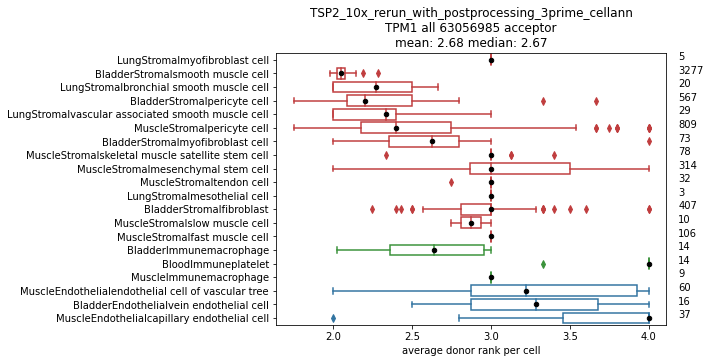

ranks 3.0    19
2.0    16
4.0    14
1.0     5
5.0     1
6.0     1
Name: rank_don, dtype: int64
end 63056985 shared_ends [63042943, 63043831, 63044152, 63048707, 63049517, 63050141]


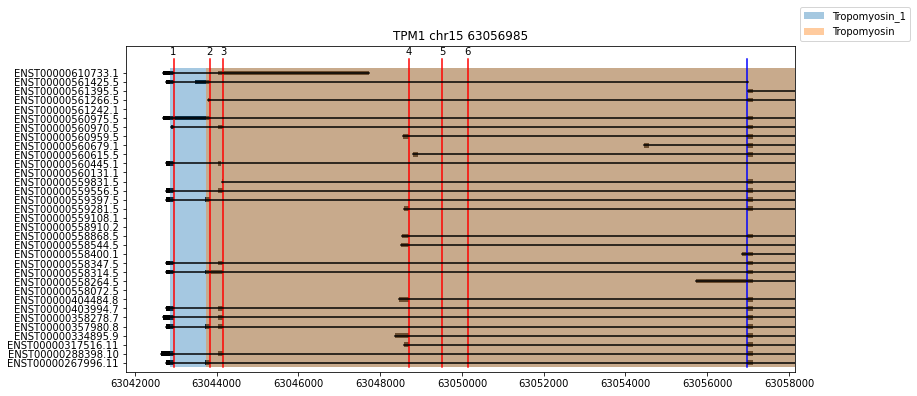

ann_dict {3: True, 2: True, 1: False, 4: True, 6: False, 5: False}


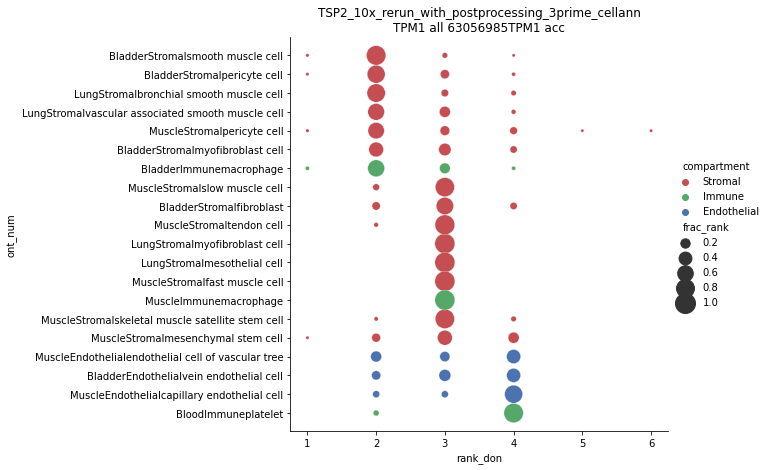

saved output/donor_boxplots/TPM1/TPM1_63056985TPM1_Bladder_TSP2_10x_rerun_with_postprocessing_3prime_cellann_acc_0.pdf


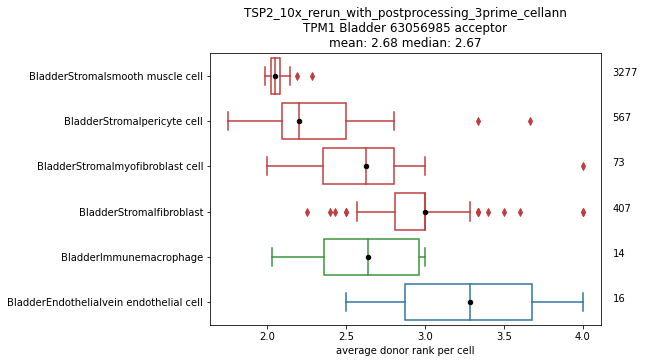

ranks 4.0    6
2.0    6
3.0    6
1.0    3
Name: rank_don, dtype: int64
end 63056985 shared_ends [63042943, 63043831, 63044152, 63048707]


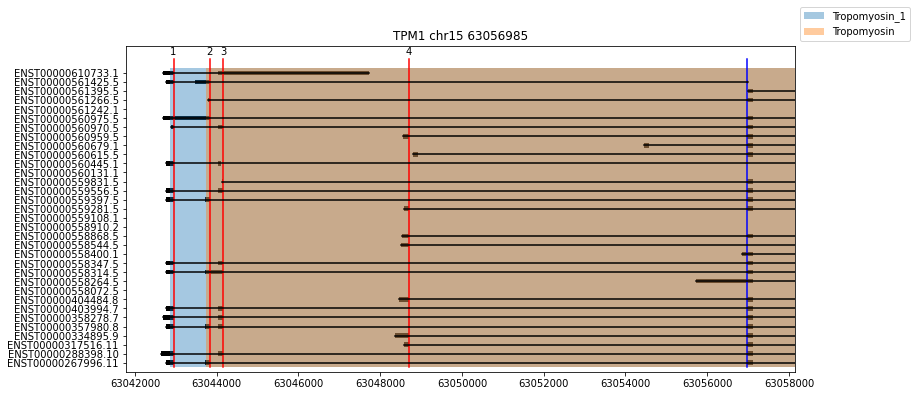

ann_dict {3: True, 2: True, 1: False, 4: True}


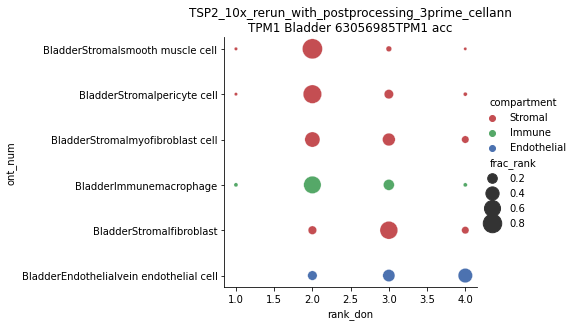

saved output/donor_boxplots/TPM1/TPM1_63056985TPM1_Blood_TSP2_10x_rerun_with_postprocessing_3prime_cellann_acc_0.pdf


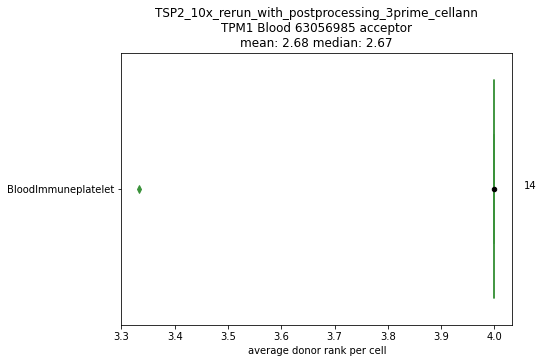

ranks 4.0    1
2.0    1
Name: rank_don, dtype: int64
end 63056985 shared_ends [63043831, 63048707]


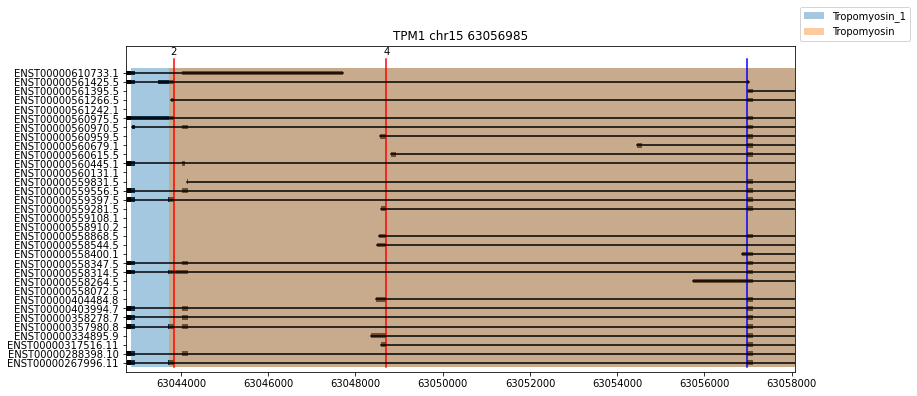

ann_dict {2: True, 4: True}


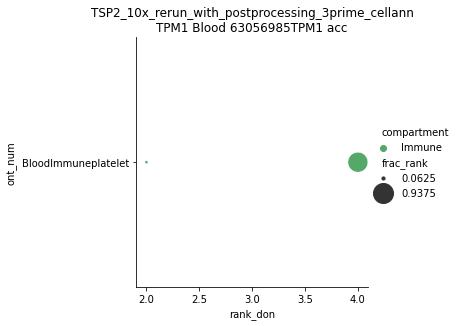

saved output/donor_boxplots/TPM1/TPM1_63056985TPM1_Lung_TSP2_10x_rerun_with_postprocessing_3prime_cellann_acc_0.pdf


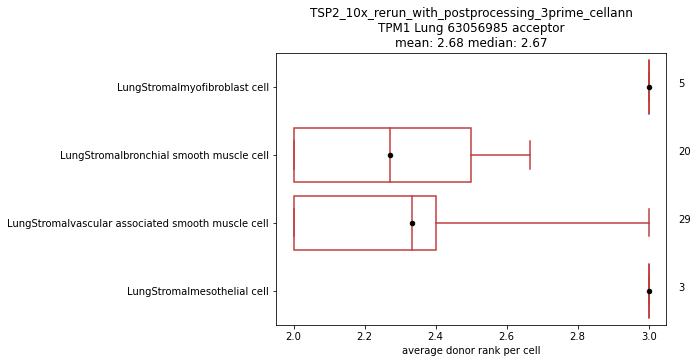

ranks 3.0    4
4.0    2
2.0    2
Name: rank_don, dtype: int64
end 63056985 shared_ends [63043831, 63044152, 63048707]


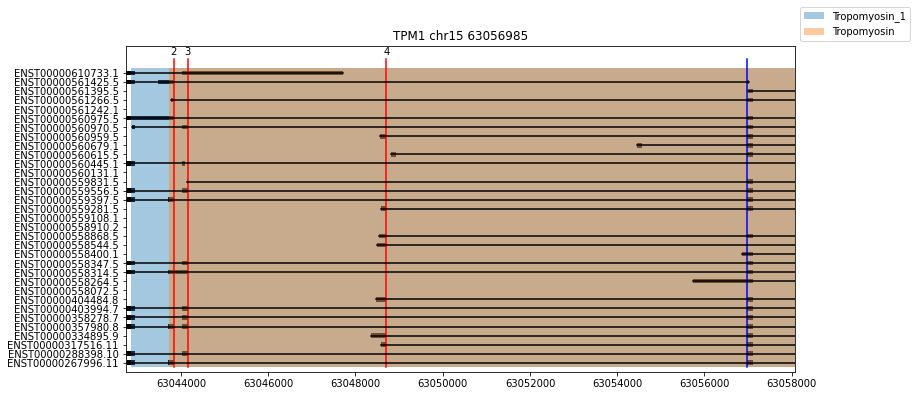

ann_dict {3: True, 2: True, 4: True}


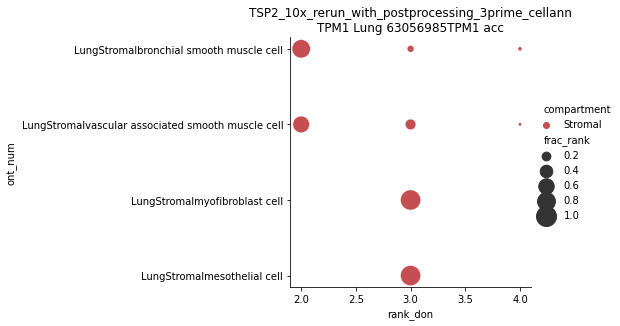

saved output/donor_boxplots/TPM1/TPM1_63056985TPM1_Muscle_TSP2_10x_rerun_with_postprocessing_3prime_cellann_acc_0.pdf


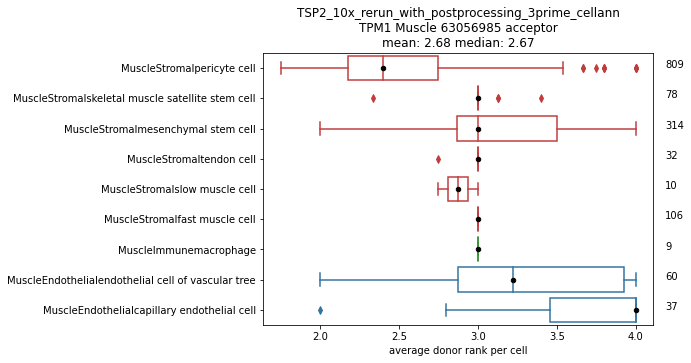

ranks 3.0    9
2.0    7
4.0    5
1.0    2
5.0    1
6.0    1
Name: rank_don, dtype: int64
end 63056985 shared_ends [63042943, 63043831, 63044152, 63048707, 63049517, 63050141]


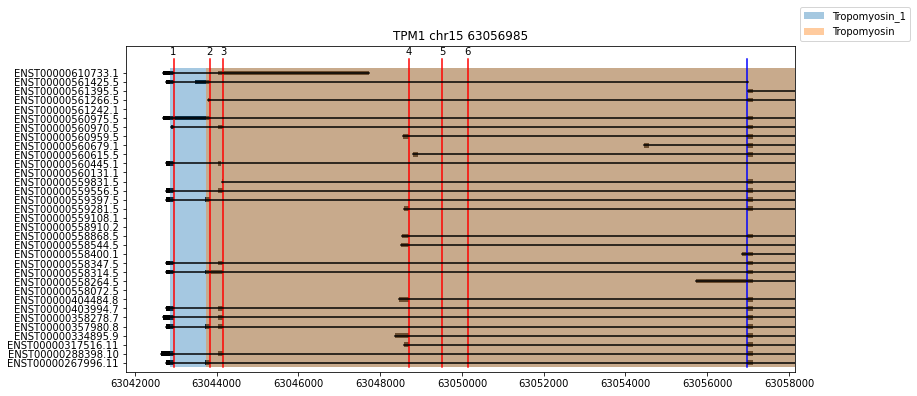

ann_dict {3: True, 4: True, 6: False, 5: False, 1: False, 2: True}


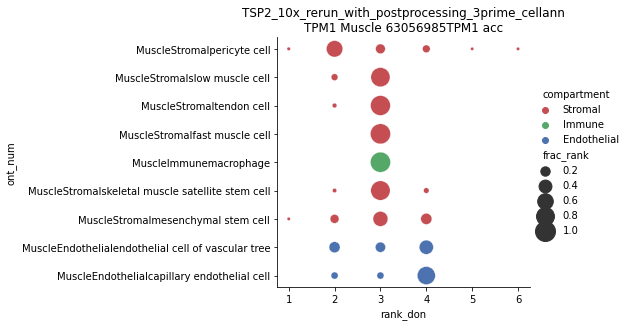

100%|██████████| 1/1 [00:18<00:00, 18.54s/it]


In [18]:


# load in coords
#  f = open("/oak/stanford/groups/horence/julias/tsp/scripts/TS_10x_redo_sym_S_0.1_z_0.0_b_5_light.tsvsplice_coor{}.tab".format(letter),"r")
#  pos_dict = defaultdict(lambda: [])
#  for line in f.readlines():
#    if not line.startswith("geneR1A_uniq"):
#      
#      line = line.split()
#      try:
#        pos_dict[line[1]].append(line[2] + line[1])
#      except:
#        print(line)
#  f.close()

pos_dict = {}
#  params = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/notebooks/output/zcontribs_to_plot/params_ATP5F1C.tsv",sep="\t")
params = pd.read_csv(params,sep="\t")

#  params = params[params["let"] == letter]

#  params = pd.DataFrame.from_dict({"gene" : ["TEX43"],"let" : ["B"], "end" : [61761838]})

pos_dict = {}
for gene, gene_df in params.groupby("gene"):
  pos_dict[gene] = list(gene_df["end"].unique())
print("params",params)



#  pos_dict = {"MYL6" : [56160320],"ATP5C1": [7802854],"IRF1" : [132490545], "CD47" : [108047292]}
#  print("pos_dict",pos_dict)
#  genes = []
#  f = open("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/sig_genes.txt","r")
#  for line in f.readlines():
#    genes.append(line[:-1])
#  f.close()

sub = True
const_color = False
comp_sort = False

let_dict = {"A" : "acc", "B" : "don"}
rev_dict = {"A" : "B", "B" : "A"}

#  exact = {"MYL6" : ["juncPosR1B",[56160626,56161387],["Artery","Capillary","Capillary Aerocyte","Lymphatic","Vein","Alveolar Epithelial Type 1","Alveolar Epithelial Type 2","Basal","Ciliated","Club","Mucous","Basophil/Mast 1","CD4+ Memory/Effector T","CD4+ Naive T","CD8+ Memory/Effector T","CD8+ Naive T","Classical Monocyte","IGSF21+ Dendritic","Macrophage","Myeloid Dendritic Type 1", "Myeloid Dendritic Type 2", "Natural Killer","Natural Killer T","Nonclassical Monocyte","Plasmacytoid Dendritic","Proliferating Macrophage","Proliferating NK/T","Adventitial Fibroblast","Airway Smooth Muscle","Alveolar Fibroblast","Myofibroblast","Pericyte","Vascular Smooth Muscle"]],
#           "CD47": ["juncPosR1A",[108049619,108050578,108051939,108057477],["Artery","Capillary","Lymphatic","Alveolar Epithelial Type 1","Alveolar Epithelial Type 2", "Basal", "Ciliated", "Club", "Mucous", "Macrophage", "Natural Killer", "OLR1+ Classical Monocyte","Proliferating Macrophage"]],
#           "CMC1": ["juncPosR1A",[28241812,28263380,28291954,28294529],["CD4+ Memory/Effector T","CD8+ Memory/Effector T","CD8+ Naive T","Macrophage","Natural Killer"]]}
exact = {}

#  compartments = ['germ', 'lymphoid', 'myeloid', 'stromal', 'epithelial',
#             'neural', 'endothelial', 'megakaryocyte-erythroid',
#                    'hematopoietic']
#  compartments = ['Endothelial', 'Epithelial', 'Immune', 'Stromal']
compartments = sorted([x for x in list(df["compartment"].unique()) if x != None])
alpha = 1
if const_color:
  palette = defaultdict(lambda : "black")
else:
  palette = compartment_colors(compartments) #{"Endothelial" : u'#1f77b4', "Stromal" : u'#ff7f0e', "Epithelial" : u'#2ca02c', "Immune" : u'#d62728'}

genes = list(pos_dict.keys())
#  genes = ["TTC23","TEX43","WDR31","TRNAR-UCU","MLF1","STMN1","LOC105861217","LOC105872934"]
#  genes = ["MYL6","RPS24","ATP5C1"]
for gene in tqdm(genes):
#   try:
    print("gene",gene)
    genepath = outpath + gene + "/"
    if not os.path.exists(genepath):
      os.makedirs(genepath)
    gene_df = df[df["geneR1A_uniq"] == gene]
    
    print("size before sub",gene_df.shape)
    if sub:
      gene_df = gene_df[gene_df["juncPosR1{}".format(letter)].isin(pos_dict[gene])]
      print("size gene_df",gene_df.shape)
    suff = ""
    
    if gene in exact.keys():

      gene_df = gene_df[gene_df[exact[gene][0]].isin(exact[gene][1])]
      gene_df = gene_df[gene_df["free_annotation"].isin(exact[gene][2])]
      suff = "_exact"
    for let in [letter]:
      if gene_df.shape[0] > 0: 
        gene_df = gene_df[gene_df["ontology"].isin(focus)]
        print("num ontologies",gene_df["ontology"].nunique())
        gene_df["sort_num"] = gene_df["ontology"].map({x : y for x, y in zip(focus,range(len(focus)))})
        gene_df = gene_df.sort_values("sort_num")
        gene_df["num_" + let_dict[let]] = gene_df["pos{}_group".format(let)].map(gene_df.groupby("pos{}_group".format(let))["pos{}_group".format(rev_dict[let])].nunique())
        gene_df = gene_df[gene_df["num_" + let_dict[let]] > 1]
        gene_df["pos{}_cell".format(let)] = gene_df["pos{}_group".format(let)] + gene_df["cell"]
        gene_df["rank_{}".format(let_dict[let])] = gene_df.groupby("pos{}_group".format(let))["juncPosR1{}".format(rev_dict[let])].rank(method="dense")
        gene_df["scaled_rank"] = gene_df["rank_" + let_dict[let]] * gene_df["numReads"]
        gene_df["num"] = gene_df["pos{}_cell".format(let)].map(gene_df.groupby("pos{}_cell".format(let))["scaled_rank"].sum())
        gene_df["denom"] = gene_df["pos{}_cell".format(let)].map(gene_df.groupby("pos{}_cell".format(let))["numReads"].sum())
        gene_df["avg_rank"] = gene_df["num"]/gene_df["denom"]
        print("gene size 2",gene_df.shape)
 #     gene_df = gene_df.drop_duplicates("pos{}_cell".format(let))
        box(gene_df, let, cell_lim, genepath, gene, dataname, let_dict, palette, rev_dict, domains, gtf,alpha, comp_sort, suff, dataname_dict)
#   except Exception as e:
#     print(e)